# **Lab 4: Approximation**
**Johan Ledéus**

# **Introduction**

Homework 4 for DD2363 Methods in Scientific Computing


# Methods

## Mandatory assignments

###1. Function: 1-point Gauss quadrature over a unit interval 

####Input: function f(x) 
####Output: quadrature approximation of integral $\int_0^1 f(x) dx$
####Test: verify exact integration of linear polynomial $ax + b$

#### Solution
The numerical integration with gauss quadrature over a unit interval is that we discretice the integral with: $\int_0^1f(x)dx \approx \sum_{i=1}^kw_if(x_i)$ where $w \in \mathbb{R}$ and $x_i \in [0,1]$ (which is the domain for this assignment).

For the one-point Gauss quadrature we have:

$$\int_a^bf(x)dx \approx w_1f(x_1), a \leq x_1 \leq b$$

Given that:
$$f(x) = m + kx$$
Which has the solution 
$$\int_a^b(m + kx)dx = [mx + \frac{kx^2}{2}]_a^b = [m(b-a) + k\frac{b^2-a^2}{2}]$$
$$w_1f(x_1) = w_1(m + kx_1) = m(w_1) + k(w_1x_1)$$
Which gives us the equation:
$$w_1 = b-a$$
$$w_1x_1 = \frac{b^2-a^2}{2}$$
Which gives us that $w_1 = b-a$ and $x_1 = \frac{b+a}{2}$

So with the one point Gauss quadrature we approximate $$\int_a^bf(x)dx \approx w_1f(x_1) = (b-a)f(\frac{a+b}{2})$$

In [0]:
def one_point_gauss_quadrature(f, a = 0, b = 1):
  return (b-a)*f((a+b)/2)

###2. Function: L2 projection to pw linear approximation over mesh in 1D

####Input: function $f(x)$, 1D mesh with nodes $(x_0,...,x_n)$
####Output: vector of L2 projection of $f(x)$ evaluated in $(x_0,...,x_n)$ 
####Test: verify accuracy and convergence rate against exact function

#### Solution
We define the $L^2$ projection of function $f \in L^2(I)$ on the pw linear approximation over the mesh as:

$$P_hf(x) = \sum_{j=0}^{m+1}\alpha_j\phi_j(x)$$

where $\phi_{j}$  is the global basis. All the equations are taken from the course litterature and are described as a comment on each def.

But the basic idea is that we want to solve the equation.

$$Mx = b$$

where  the matrix $M$ is the mass matrix described in chapter 10. 
$$M_{i,j} = (\phi_{j},\phi_{i})$$


$$b = (f,\phi_{i})$$
$$\alpha_i = x_i$$

We also know that the $L^2$ inner product is defined by:
$$(f,g) = \int_a^bf(x)g(x)dx$$

Which was used for calculating $b = (f,\phi_{i})$. I used the trapezoidal rule to approximate the integral.


In [0]:
import numpy as np

# Matrix assembly page 140-141
def mass_matrix(mesh):
  m = len(mesh)
  M = np.zeros((m,m))
  
  h_1 = mesh[1] - mesh[0]
  h_2 = mesh[2] - mesh[1]
  M[0][0] += h_1/3 + h_2/3
  M[0][1] += h_1/6
  
  M[-1][-1] += h_1/3 + h_2/3
  M[-1][m-2] += h_1/6
  
  for i in range(1,m-2):
    h_1 = mesh[i+1] - mesh[i]
    h_2 = mesh[i+2] - mesh[i+1]
    M[i][i] += h_1/3 + h_2/3
    M[i][i+1] += h_1/6
    M[i][i-1] += h_1/6
  return M

# f(x_i) + f(x_i+1)*h / 2
def quad_trapezoidal(f,mesh):
  m = len(mesh)
  b = np.zeros(m)
  b[-1] = f(mesh[-1])*(mesh[-1] - mesh[m-2])/2
  b[0] = f(mesh[0])*(mesh[1] - mesh[0])/2
  for i in range(1,m-1):
    h = (mesh[i+1] - mesh[i])
    b[i] = h*(f(mesh[i]) + f(mesh[i+1])) / 2
  return b

# Eq 10.21
def lambda_0(x,x1,x2):
  return (x2 - x) / (x2 - x1)

# Eq 10.22
def lambda_1(x,x1,x2):
   return (x-x1) / (x2 - x1)

# eq 10.24
def phi(i,x,mesh):
  if x >= mesh[i] and x <= mesh[i+1]:  
    return lambda_1(x,mesh[i], mesh[i+1])
  if x >= mesh[i+1] and x <= mesh[i+2]:
    return lambda_0(x,mesh[i+1], mesh[i+2])
  return 0


def l2_projection_pw(f, a_i = 0, b_i = 1, steps = 100):
  
  # Generate the mesh
  step_size = (b_i - a_i) / steps
  mesh = np.arange(a_i-step_size*5, b_i+step_size*5, step_size)
  
  # Create the mass matrix
  M = mass_matrix(mesh)
  
  # Create b
  b = quad_trapezoidal(f,mesh)
  
  # Least square to calculate x
  x = np.linalg.lstsq(M,b, rcond=None)[0]

  res = [] # Projected values
  res2 = [] # Actual values
  x_label = [] # Mesh values
  
  for i in range(len(mesh)):
    if(mesh[i] >= a_i and mesh[i] <= b_i):
      x_label.append(mesh[i])
      res.append(0)
      for j in range(len(mesh)-1):
        res[-1] += phi(j,mesh[i],mesh)*x[j]
      res2.append(f(mesh[i]))
   
  return res, res2, x_label


# Results

### 1. Function: 1-point Gauss quadrature over a unit interval 

When verifying the integration with the polinomial $2x-3$ which has the exact solution $-2$ the results are correct. Given the theory in chapter 12 and the derivation in the assignment, we can see that the results are exact for linear polynomials.

In [44]:
# Test for assignment 1
f = lambda x : 2*x - 3
assert one_point_gauss_quadrature(f) == -2
print("Pass")

Pass


###2. Function: L2 projection to pw linear approximation over mesh in 1D

As we can see in the last figure the error from the actual values decreases when we increase the discretized mesh. Meaning that we add more points to improve the accuracy of the approximation. In the ficure below the red-dotted line is the projection and the blue is the function value. 

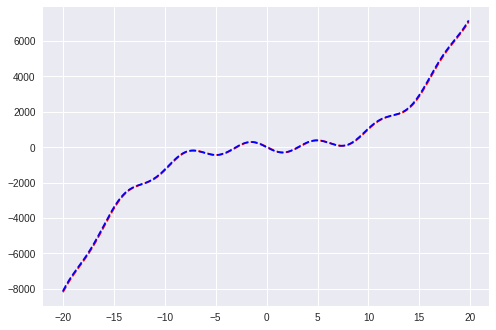

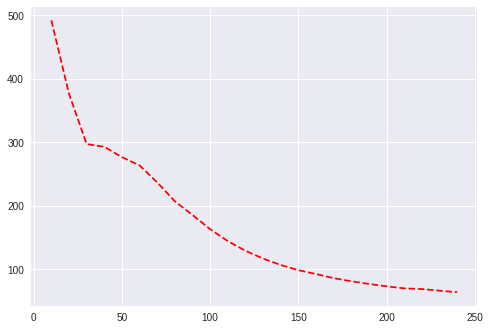

In [45]:
# Test for assignment 2
f = lambda x : 300*np.sin(-x) + x**3 - x**2

# Plot
proj, func_val, mesh = l2_projection_pw(f,-20,20, 250)
import matplotlib.pyplot as plt
plt.plot(mesh, proj, 'r--', mesh, func_val,'b--')
plt.show()

# Convergence 
res = []
lab = []
for x in [10*x for x in range(1,25)]:
  
  proj, func_val, mesh = l2_projection_pw(f,-20,20, x)
  lab.append(x)
  res.append(0)
  for j in range(2,10):
    res[-1] += np.abs(proj[j] - func_val[j])
  res[-1] /= 9

    
plt.plot(lab, res, 'r--')
plt.show() 


# Discussion

The first assignment was pretty straight forward since it was a familiar concept. The second assignment required more steps and I assume that you can calculate the results in a more efficient manner. It was also more difficult to put all the pieces together.